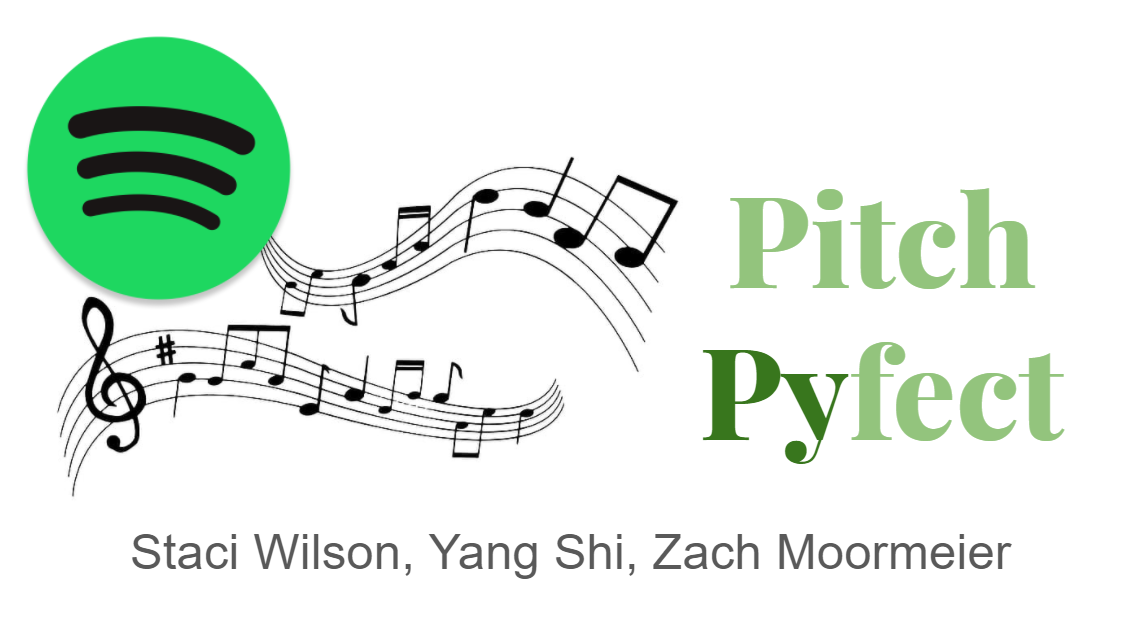

## Dependencies and Setup

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import json
import os
import re
import requests
import pylab

from api_keys import api_key
from pprint import pprint

genres_6_df=pd.read_csv("Input_Data/artists-data.csv")
tracks_1200k_df=pd.read_csv("Input_Data/tracks_features.csv")
tracks_175k_df=pd.read_csv("Input_Data/data.csv")
lyrics_data_df=pd.read_csv("Input_Data/lyrics-data.csv")
labeled_lyrics_df=pd.read_csv("Input_Data/labeled_lyrics_cleaned.csv")

## 1.0 Music Theory Data Cleanup & Exploration

In [59]:
# check for null values in the dataframe
print(genres_6_df.isnull().values.any())
print(tracks_1200k_df.isnull().values.any())
print(tracks_175k_df.isnull().values.any())
print(lyrics_data_df.isnull().values.any())

True
False
False
True


In [60]:
genres_3_df=genres_6_df.loc[(genres_6_df['Genre']=='Rock')|(genres_6_df['Genre']=='Pop')|
                            (genres_6_df['Genre']=='Hip Hop'),['Artist', 'Genre']].copy()
genres_3_df=genres_3_df.dropna()
genres_3_df = genres_3_df.apply(lambda x: x.str.lower() if x.dtype=='object' else x)
genres_3_df

,Artist,Genre
0,10000 maniacs,rock
1,12 stones,rock
2,311,rock
3,4 non blondes,rock
4,a cruz está vazia,rock
...,...,...
3227,tati quebra barraco,hip hop
3228,valesca popozuda,pop
3229,vine rodry,pop
3234,leandro sapucahy,pop


In [61]:
tracks_1200k_df=tracks_1200k_df[['name',  'artists',  'explicit', 'key',  'mode', 'acousticness','valence', 'tempo', 'duration_ms','year']]
tracks_175k_df=tracks_175k_df[['name','artists',  'explicit', 'key','mode',  'acousticness', 'valence','tempo', 'duration_ms', 'year']]
tracks_175k_df["explicit"] = tracks_175k_df["explicit"].astype('bool')
tracks_all_df=pd.concat([tracks_1200k_df,tracks_175k_df])
tracks_all_df = tracks_all_df.apply(lambda x: x.str.lower() if x.dtype=='object' else x)

artists_list=tracks_all_df['artists']
artists_lean_list=[artist[2:-2] for artist in artists_list]
tracks_all_df['Artist']=artists_lean_list

tracks_df=pd.merge(tracks_all_df,genres_3_df, on='Artist',how='outer')
tracks_df['genre']=tracks_df['Genre']
tracks_df=tracks_df.dropna()

tracks_df = tracks_df.groupby(['name', 'artists','genre']).first()
tracks_df

,,,explicit,key,mode,acousticness,valence,tempo,duration_ms,year,Artist,Genre
name,artists,genre,,,,,,,,,,
"""40""",['u2'],rock,False,8.0,1.0,0.228000,0.338,150.166,157840.0,1983.0,u2,rock
"""40"" - live",['u2'],rock,False,8.0,1.0,0.099800,0.279,143.079,226200.0,1983.0,u2,rock
"""40"" - remastered 2008",['u2'],rock,False,8.0,1.0,0.185000,0.310,150.316,157667.0,1983.0,u2,rock
"""cassius"" love vs. ""sonny"" wilson - remastered 2001",['the beach boys'],rock,False,10.0,0.0,0.596000,0.487,149.984,211560.0,1964.0,the beach boys,rock
"""heroes"" - live, glastonbury, 2000",['david bowie'],rock,False,7.0,1.0,0.032300,0.607,115.007,357960.0,2018.0,david bowie,rock
...,...,...,...,...,...,...,...,...,...,...,...,...
絲,['the gazette'],rock,False,4.0,0.0,0.021200,0.220,114.994,403293.0,2017.0,the gazette,rock
虚 蜩,['the gazette'],rock,False,11.0,1.0,0.000014,0.336,199.523,227307.0,2018.0,the gazette,rock
裏切る舌,['the gazette'],rock,False,11.0,1.0,0.000002,0.485,154.954,210280.0,2018.0,the gazette,rock


In [62]:
music_theory_df=tracks_df[['Artist','Genre','key','mode', 'valence','tempo','year']].copy()

keys_list=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
for i in range (0,12):
    music_theory_df.loc[(music_theory_df.key==i),'key']=keys_list[i]


# assign modes with its non_numerical value
modes=['Minor','Major']
for i in range (0,2):    
    music_theory_df.loc[(music_theory_df['mode']==i),'mode']=modes[i]

music_theory_df 

,,,Artist,Genre,key,mode,valence,tempo,year
name,artists,genre,,,,,,,
"""40""",['u2'],rock,u2,rock,G#,Major,0.338,150.166,1983.0
"""40"" - live",['u2'],rock,u2,rock,G#,Major,0.279,143.079,1983.0
"""40"" - remastered 2008",['u2'],rock,u2,rock,G#,Major,0.310,150.316,1983.0
"""cassius"" love vs. ""sonny"" wilson - remastered 2001",['the beach boys'],rock,the beach boys,rock,A#,Minor,0.487,149.984,1964.0
"""heroes"" - live, glastonbury, 2000",['david bowie'],rock,david bowie,rock,G,Major,0.607,115.007,2018.0
...,...,...,...,...,...,...,...,...,...
絲,['the gazette'],rock,the gazette,rock,E,Minor,0.220,114.994,2017.0
虚 蜩,['the gazette'],rock,the gazette,rock,B,Major,0.336,199.523,2018.0
裏切る舌,['the gazette'],rock,the gazette,rock,B,Major,0.485,154.954,2018.0


In [ ]:
lyrics_data_df = lyrics_data_df.apply(lambda x: x.str.lower() if x.dtype=='object' else x)
labeled_lyrics_df = labeled_lyrics_df.apply(lambda x: x.str.lower() if x.dtype=='object' else x)

labeled_lyrics_df=labeled_lyrics_df.rename(columns={"artist": "Artist", "seq": "Lyric",'song':'SName'})
labeled_lyrics_df=labeled_lyrics_df[['Artist','SName','Lyric']]

alink_list=lyrics_data_df['ALink']
alink_lean_list=[artist[1:-1] for artist in alink_list]
lyrics_data_df['Artist']=alink_lean_list

data_lyrics_df=lyrics_data_df.loc[lyrics_data_df['Idiom']=='english',['Artist','SName','Lyric']]
lyrics_all_df=pd.concat([labeled_lyrics_df,data_lyrics_df])
lyrics_df=pd.merge(lyrics_all_df,genres_3_df, on='Artist',how='outer')
lyrics_df=lyrics_df.dropna()
lyrics_df=lyrics_df.drop_duplicates(subset=['Artist','Genre','SName'])

In [64]:
lyrics_df

## 1.1 Music Theory -- Key and Time Signatures

Songs are composed in key signatures.  The most commonly used key signatures are C, G, D, and A.


In [8]:
rock_df=music_theory_df.loc[music_theory_df['Genre'].str.contains('rock'),:]
pop_df=music_theory_df.loc[music_theory_df['Genre'].str.contains('pop'),:]
hiphop_df=music_theory_df.loc[music_theory_df['Genre'].str.contains('hip hop'),:]

<IPython.core.display.Javascript object>


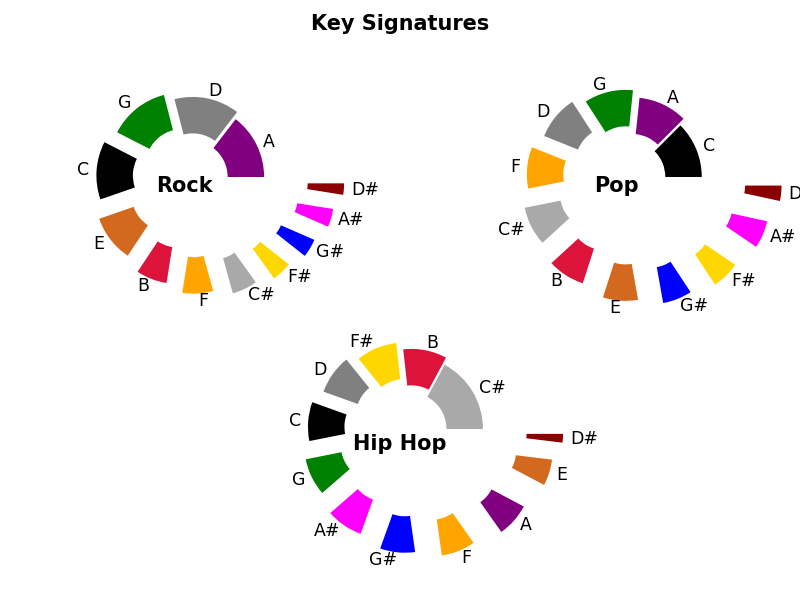

In [9]:
keys_list=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
key_color_list=['black', 'darkgray','gray','darkred','chocolate','orange','gold', 'green','blue','purple', 'fuchsia', 'crimson']
res = {keys_list[i]: key_color_list[i] for i in range(len(keys_list))}

explode=np.arange(0,1.2,0.1)
key_rock_count=rock_df['key'].value_counts()
key_pop_count=pop_df['key'].value_counts()
key_hiphop_count=hiphop_df['key'].value_counts()

color_rock_list=[res[key_signature] for key_signature in key_rock_count.keys()]
color_pop_list=[res[key_signature] for key_signature in key_pop_count.keys()]
color_hiphop_list=[res[key_signature] for key_signature in key_hiphop_count.keys()]
%matplotlib notebook
fig = plt.figure()
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(233)
ax3 = fig.add_subplot(235)


fig.text(0.5, 0.95, 'Key Signatures',horizontalalignment='center', color='black', weight='bold',size='large')
fig.text(0.23, 0.68, 'Rock',horizontalalignment='center', color='black', weight='bold',size='large')
fig.text(0.77, 0.68, 'Pop',horizontalalignment='center', color='black', weight='bold',size='large')
fig.text(0.5, 0.25, 'Hip Hop',horizontalalignment='center', color='black', weight='bold',size='large')

ax1.pie(key_rock_count,wedgeprops=dict(width=0.5),explode=explode, labels=key_rock_count.keys(),colors=color_rock_list)
ax2.pie(key_pop_count, wedgeprops=dict(width=0.5),explode=explode,labels=key_pop_count.keys(),colors=color_pop_list)
ax3.pie(key_hiphop_count,wedgeprops=dict(width=0.5),explode=explode, labels=key_hiphop_count.keys(),colors=color_hiphop_list)

plt.show()

## 1.2 Music Theory -- Mode and Valence


<IPython.core.display.Javascript object>


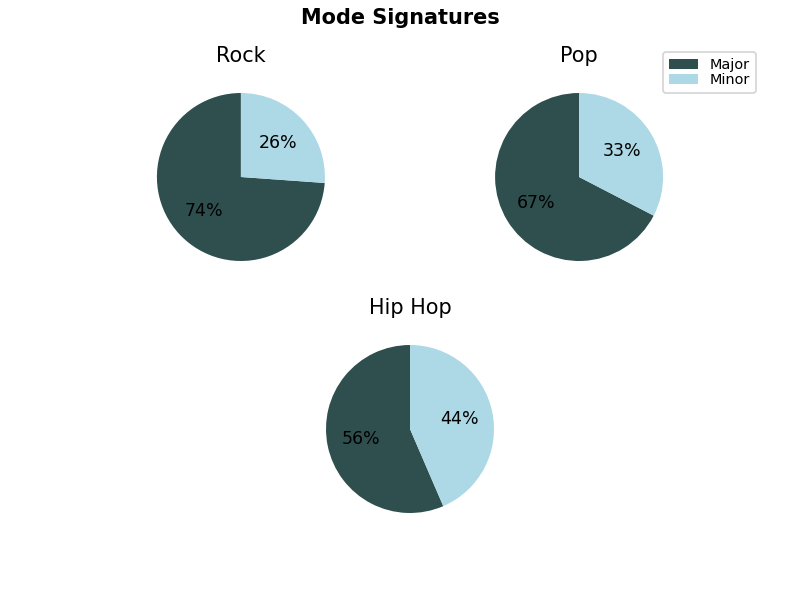

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

ax1.title.set_text('Rock')
ax2.title.set_text('Pop')
ax3.title.set_text('Hip Hop')

mode_rock_count=rock_df['mode'].value_counts()
mode_pop_count=pop_df['mode'].value_counts()
mode_hiphop_count=hiphop_df['mode'].value_counts()

ax1.pie(mode_rock_count, autopct='%1.0f%%',colors=['darkslategray','lightblue'], startangle=90)
ax2.pie(mode_pop_count, autopct='%1.0f%%',colors=['darkslategray','lightblue'], startangle=90)
ax3.pie(mode_hiphop_count, autopct='%1.0f%%',colors=['darkslategray','lightblue'], startangle=90)

fig.text(0.5, 0.96, 'Mode Signatures',horizontalalignment='center', color='black', weight='bold',size='large')
labels = mode_rock_count.keys()
legend = ax2.legend(labels, loc=(0.9, .9),labelspacing=0.1, fontsize='small')
plt.show()

<IPython.core.display.Javascript object>


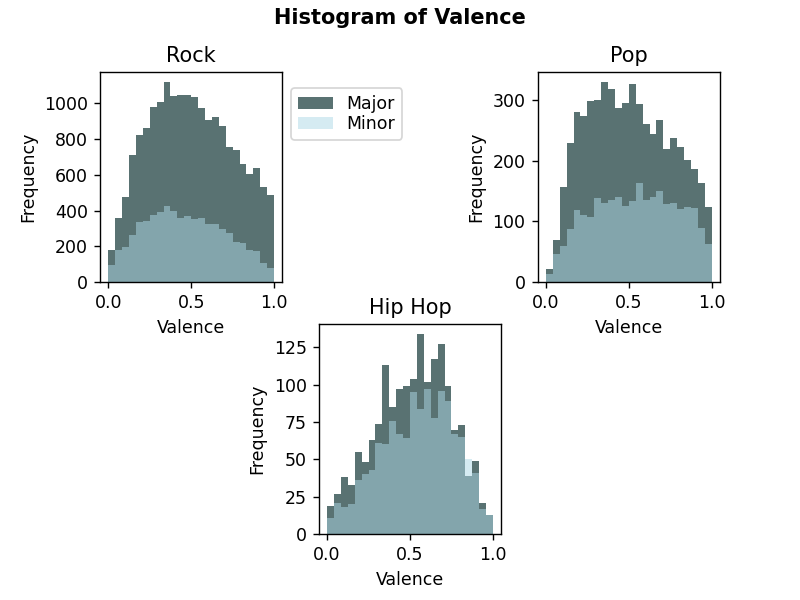

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(233)
ax3 = fig.add_subplot(235)

ax1.title.set_text('Rock')
ax2.title.set_text('Pop')
ax3.title.set_text('Hip Hop')

bins = np.linspace(0,1,25)

major_rock =rock_df.loc[rock_df['mode']=='Major',['valence']].copy()
minor_rock =rock_df.loc[rock_df['mode']=='Minor',['valence']].copy()
major_pop =pop_df.loc[pop_df['mode']=='Major',['valence']].copy()
minor_pop =pop_df.loc[pop_df['mode']=='Minor',['valence']].copy()
major_hiphop =hiphop_df.loc[hiphop_df['mode']=='Major',['valence']].copy()
minor_hiphop =hiphop_df.loc[hiphop_df['mode']=='Minor',['valence']].copy()

ax1.hist(major_rock['valence'], bins, label='Major',alpha=0.8,color='darkslategray')
ax1.hist(minor_rock['valence'], bins, label='Minor',alpha=0.5, color='lightblue')
ax2.hist(major_pop['valence'], bins, label='Major',alpha=0.8,color='darkslategray')
ax2.hist(minor_pop['valence'], bins, label='Minor', alpha=0.5,color='lightblue')
ax3.hist(major_hiphop['valence'], bins, label='Major',alpha=0.8,color='darkslategray')
ax3.hist(minor_hiphop['valence'], bins, label='Minor',alpha=0.5, color='lightblue')

fig.text(0.5, 0.96, 'Histogram of Valence',horizontalalignment='center', color='black', weight='bold',size='large')
labels = mode_rock_count.keys()
legend = ax1.legend(labels, bbox_to_anchor=[1, 0.8],loc='center left',labelspacing=0.1)

ax1.set(ylabel='Frequency',xlabel='Valence')
ax2.set(ylabel='Frequency',xlabel='Valence')
ax3.set(ylabel='Frequency',xlabel='Valence')

plt.show()

## 1.3 Music Theory -- Tempo 

Most songs on spotify have a tempo that falls between 75 and 150 beats per minute.


<IPython.core.display.Javascript object>


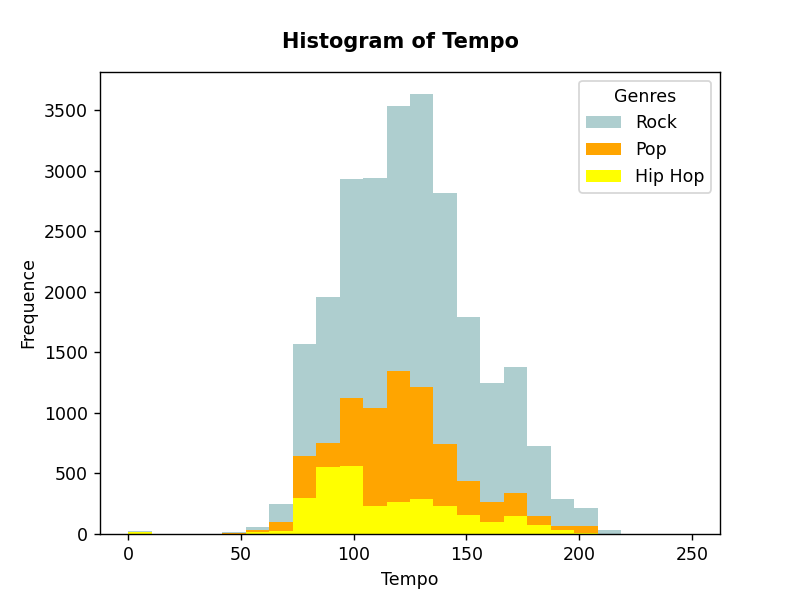

In [14]:
fig = plt.figure()
bins = np.linspace(0,250,25)

plt.hist(rock_df['tempo'], bins, alpha=0.5,color='cadetblue')
plt.hist(pop_df['tempo'], bins, alpha=1,color='orange')
plt.hist(hiphop_df['tempo'], bins, alpha=1,color='yellow')

fig.text(0.5, 0.92, 'Histogram of Tempo',horizontalalignment='center', color='black', weight='bold',size='large')
plt.ylabel('Frequence')
plt.xlabel('Tempo')
plt.legend(['Rock','Pop','Hip Hop'],
          title="Genres",
          loc="upper right")
plt.show()

## 2.1 Music Lyrics 



In [68]:
rock_lyrics_df=lyrics_df.loc[lyrics_df['Genre'].str.contains('rock'),:]
pop_lyrics_df=lyrics_df.loc[lyrics_df['Genre'].str.contains('pop'),:]
hiphop_lyrics_df=lyrics_df.loc[lyrics_df['Genre'].str.contains('hip hop'),:]

In [71]:
paragraphs=rock_lyrics_df['Lyric']
paragraph_word=[]

for paragraph in paragraphs:
    paragraph_word=paragraph_word+(re.findall(r"[\w']+|[.,!?;]", paragraph))

word_df=pd.DataFrame({'words':paragraph_word})   
word_count_df=pd.DataFrame(word_df.value_counts())
word_count_df.to_csv('Output_Data/rock_word_count.csv')
word_count_df

,0
words,
.,434313
the,218337
",",213733
you,183442
i,179032
...,...
hennessy,1
swimsuit,1
hens,1


In [69]:

paragraphs=pop_lyrics_df['Lyric']
paragraph_word=[]

for paragraph in paragraphs:
    paragraph_word=paragraph_word+(re.findall(r"[\w']+|[.,!?;]", paragraph))

word_df=pd.DataFrame({'words':paragraph_word})   
word_count_df=pd.DataFrame(word_df.value_counts())
word_count_df.to_csv('Output_Data/pop_word_count.csv')
word_count_df

,0
words,
.,362000
",",160869
you,138360
i,128865
the,112297
...,...
luminal,1
luminous,1
lumpy,1


In [70]:
paragraphs=hiphop_lyrics_df['Lyric']
paragraph_word=[]

for paragraph in paragraphs:
    paragraph_word=paragraph_word+(re.findall(r"[\w']+|[.,!?;]", paragraph))

word_df=pd.DataFrame({'words':paragraph_word})   
word_count_df=pd.DataFrame(word_df.value_counts())
word_count_df.to_csv('Output_Data/hiphop_word_count.csv')
word_count_df

,0
words,
.,380461
",",198560
i,124220
the,121983
you,112990
...,...
pore,1
porco,1
porchfloor,1


## 3.1 NYT API